<a href="https://colab.research.google.com/github/abdelkadergelany/Intrusion-Detection-in-IoT-Based-Network/blob/main/Protocol_AnalyZer_Almost_Completed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing  Libraries

In [38]:
# data cleaning and plots
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# sklearn: data preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder ,MinMaxScaler
from sklearn import preprocessing,svm,metrics

# sklearn: train model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report

# sklearn classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier

#Feature selection
from sklearn.feature_selection import chi2,RFE
from sklearn.feature_selection import SelectKBest
import xgboost, lightgbm
from sklearn.svm import SVR

# Data Processing

## Load Data

**UNSW-NB15: a comprehensive data set for network intrusion detection systems**


attack_cat: This dataset has nine types of attacks, namely, Fuzzers, Analysis, Backdoors, DoS, Exploits, Generic, Reconnaissance, Shellcode and Worms.

Label: 0 for normal and 1 for attack records

In [39]:
# Load data
train = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_training-set.csv')
test = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_testing-set.csv')
combined_data = pd.concat([train, test]).drop(['id'],axis=1)

In [40]:
# Look at the first 5 rows
combined_data.head(n=5)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0


In [41]:
# information of the data: 
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257673 entries, 0 to 82331
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dur                257673 non-null  float64
 1   proto              257673 non-null  object 
 2   service            257673 non-null  object 
 3   state              257673 non-null  object 
 4   spkts              257673 non-null  int64  
 5   dpkts              257673 non-null  int64  
 6   sbytes             257673 non-null  int64  
 7   dbytes             257673 non-null  int64  
 8   rate               257673 non-null  float64
 9   sttl               257673 non-null  int64  
 10  dttl               257673 non-null  int64  
 11  sload              257673 non-null  float64
 12  dload              257673 non-null  float64
 13  sloss              257673 non-null  int64  
 14  dloss              257673 non-null  int64  
 15  sinpkt             257673 non-null  float64
 16  din

In [43]:
# check if there are Null values
combined_data.isnull().sum()

dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat           0
label      

In [45]:
# Discard the rows with missing values

data_to_use = combined_data.dropna()

# Shape of the data: we could see that the number of rows remains the same as no null values were reported
data_to_use.shape

(257673, 44)

<h1>Contamination mean pollution (outliers) in data</h1>

In [46]:
# Contaminsation mean pollution (outliers) in data
tmp = train.where(train['attack_cat'] == "Normal").dropna()
contamination = round(1 - len(tmp)/len(train), 2)
print("train contamination ", contamination)

tmp = test.where(test['attack_cat'] == "Normal").dropna()
print("test  contamination ", round(1 - len(tmp)/len(test),2),'\n')

if contamination > 0.5:
    print(f'contamination is {contamination}, which is greater than 0.5. Fixing...')
    contamination = round(1-contamination,2)
    print(f'contamination is now {contamination}')

train contamination  0.68
test  contamination  0.55 

contamination is 0.68, which is greater than 0.5. Fixing...
contamination is now 0.32


#Visualizing The Contamination





In [47]:
# Calculate Y2 ratio
def data_ratio(y2):
    '''
    Calculate Y2's ratio
    '''
    unique, count = np.unique(y2, return_counts=True)
    ratio = round(count[0]/count[1], 1)
    return f'{ratio}:1 ({count[0]}/{count[1]})'

In [48]:
combined_data = pd.concat([train, test]).drop(['id'],axis=1)
attacks_type = combined_data['attack_cat'].values
class_type = combined_data['label'].values

The class ratio for the original data: 1.1:1 (2677/2329)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


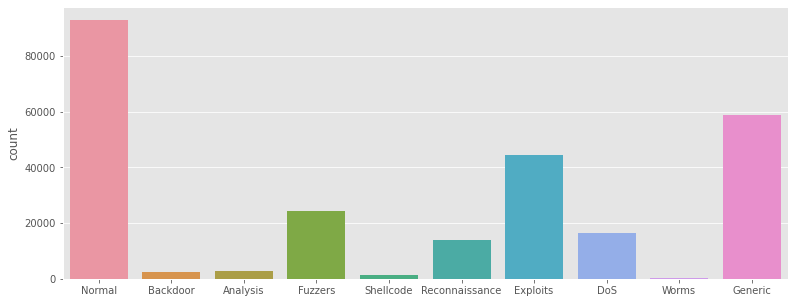

The class ratio for the original data: 0.6:1 (93000/164673)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


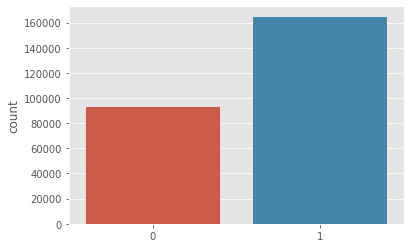

In [49]:
print('The class ratio for the original data:', data_ratio(attacks_type))
plt.figure(figsize=(13,5))
sns.countplot(attacks_type,label="Sum")
plt.show()

print('The class ratio for the original data:', data_ratio(class_type))
sns.countplot(class_type,label="Sum")
plt.show()

In [14]:
combined_data.head(2)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.2956,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.0,0.0,0.0,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.9150,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.0,0.0,0.0,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0


#Protocol Analyzer

In [50]:
#Explore different protocols
import collections
from tabulate import tabulate
counter = collections.Counter(combined_data['proto'])  
print(tabulate(counter.most_common(),headers = ['Type','Occurences']))

Type           Occurences
-----------  ------------
tcp                123041
udp                 92701
unas                15599
arp                  3846
ospf                 3271
sctp                 1474
any                   396
gre                   313
rsvp                  264
ipv6                  262
sun-nd                255
swipe                 253
mobile                253
pim                   253
sep                   251
prm                   133
xns-idp               133
leaf-1                133
ddp                   132
ipv6-frag             132
cftp                  132
wsn                   132
pvp                   132
wb-expak              132
mtp                   132
pri-enc               132
sat-mon               132
cphb                  132
iso-ip                132
xtp                   132
il                    132
mfe-nsp               132
3pc                   132
ipv6-route            132
idrp                  132
bna                   132
kryptolan   

In [51]:
#Separate data according to protocol
udp_data = combined_data.where(combined_data['proto'] == "udp").dropna()
tcp_data = combined_data.where(combined_data['proto'] == "tcp").dropna()
other_prot_data =  combined_data.where(combined_data['proto'] != "tcp").dropna()
other_prot_data =  other_prot_data.where(other_prot_data['proto'] != "udp").dropna()


In [52]:
tcp_data.shape

(123041, 44)

#Encoding non numeric Values

In [53]:
#define function to encode categorical values from data
def encode_data(data):
    le1 = LabelEncoder()
    le = LabelEncoder()
    vector = data['attack_cat']

    print("attack cat:", set(list(vector))) # use print to make it print on single line 

    data['attack_cat'] = le1.fit_transform(vector)
    data['proto'] = le.fit_transform(data['proto'])
    data['service'] = le.fit_transform(data['service'])
    data['state'] = le.fit_transform(data['state'])
    return data


In [54]:
udp_data = encode_data( udp_data)
tcp_data = encode_data( tcp_data)
other_prot_data = encode_data( other_prot_data)

attack cat: {'Shellcode', 'Generic', 'Backdoor', 'DoS', 'Exploits', 'Normal', 'Worms', 'Fuzzers', 'Reconnaissance'}
attack cat: {'Analysis', 'Shellcode', 'Generic', 'Backdoor', 'DoS', 'Exploits', 'Normal', 'Worms', 'Fuzzers', 'Reconnaissance'}
attack cat: {'Analysis', 'Generic', 'Backdoor', 'DoS', 'Exploits', 'Normal', 'Fuzzers', 'Reconnaissance'}


#Normalizing Dataset

In [56]:
def normalize_data(data):
    scaler = preprocessing.MinMaxScaler()
    names = data.columns
    d = scaler.fit_transform(data)
    scaled_df = pd.DataFrame(d, columns=names)
    return scaled_df

In [57]:
udp_data = normalize_data( udp_data)
tcp_data = normalize_data( tcp_data)
other_prot_data = normalize_data( other_prot_data)

<h1>Splitting the dataset</h1>

In [58]:
# droped label
udp_data_x = udp_data.drop(['attack_cat','label'], axis=1) 
udp_data_y = udp_data.loc[:,['label']]

tcp_data_x = tcp_data.drop(['attack_cat','label'], axis=1) 
tcp_data_y = tcp_data.loc[:,['label']]

other_data_x = other_prot_data.drop(['attack_cat','label'], axis=1) 
other_data_y = other_prot_data.loc[:,['label']]

udp_X_train, udp_X_test, udp_y_train, udp_y_test = train_test_split(udp_data_x, udp_data_y, test_size=.20, random_state=42) 
tcp_X_train, tcp_X_test, tcp_y_train, tcp_y_test = train_test_split(tcp_data_x, tcp_data_y, test_size=.20, random_state=42) 
other_X_train, other_X_test, other_y_train, other_y_test = train_test_split(other_data_x, other_data_y, test_size=.20, random_state=42) 

#Features selection

In [59]:
#Feature selection with chi2
def feat_select_chi2(data_x,data_y):
  chi2_selector = SelectKBest(chi2, k=25)
  X_train_kbest = chi2_selector.fit_transform(data_x, data_y)
  return X_train_kbest

In [60]:
#Feature selection with RFE
def feat_select_RFE(data_x,data_y):
  estimator = DecisionTreeClassifier()
  selector = RFE(estimator, n_features_to_select=25, step=1)
  data_transform = selector.fit_transform(data_x, data_y) 
  return data_transform

In [61]:
type(udp_y_train)

pandas.core.frame.DataFrame

<h1>Estimate score </h1>

In [62]:
# ===== Step 1: cross-validation ========

def estimate_score(clf,x_train,y_train):
    #clf = svm.SVC(kernel='linear') # Linear Kernel

    # define  Stratified 5-fold cross-validator, it provides train/validate indices to split data in train/validate sets.
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

    # define metrics for evaluating
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

    #perform the 5-fold CV and get the metrics results
    cv_results = cross_validate(estimator=clf,
                            X = x_train,
                            y = y_train, 
                            scoring = scoring,
                            cv = cv,
                            return_train_score = False)
    return cv_results

In [63]:
# ======== Step 2: Evaluate the model using testing data =======

def evaluate_model(type,clf,x_train_d,x_test_d,y_train_d,y_test_d):
    
    # fit the Logistic Regression model
    if type == 'knn':
        clf.fit(X=x_train_d)
    else:
        clf.fit(X=x_train_d, y=y_train_d)

    # predition on testing data
    y_pred_class = clf.predict(X=x_test_d)
    y_pred_score = clf.predict_proba(X=x_test_d)[:, 1]

    # AUC of ROC
    auc_ontest = roc_auc_score(y_true=y_test_d, y_score=y_pred_score)
    # confusion matrix
    cm_ontest = confusion_matrix(y_true=y_test_d, y_pred=y_pred_class)
    # precision score
    precision_ontest = precision_score(y_true=y_test_d, y_pred=y_pred_class)
    # recall score
    recall_ontest = recall_score(y_true=y_test_d, y_pred=y_pred_class)
    # classifition report
    cls_report_ontest = classification_report(y_true=y_test_d, y_pred=y_pred_class)

    # print the above results
    print('The model scores {:1.5f} ROC AUC on the test set.'.format(auc_ontest))
    print('The precision score on the test set: {:1.5f}'.format(precision_ontest))
    print('The recall score on the test set: {:1.5f}'.format(recall_ontest))
    print('Confusion Matrix:\n', cm_ontest)
    # Print classification report:
    print('Classification Report:\n', cls_report_ontest)

<h1>Print CV _Results</h1>

In [64]:
def print_cv_results(cv_results):
    for key, value in cv_results.items(): 
      print( key,value.mean())

#UDP Modul

<h1>Estimation of SVM on Chi2 </h1>

In [65]:
clf_svm = svm.SVC(kernel='linear',probability=True)
estimation = estimate_score(clf_svm,feat_select_chi2(udp_X_train,udp_y_train),udp_y_train['label'].values)
print_cv_results(estimation)

fit_time 128.50690360069274
score_time 5.781245422363281
test_accuracy 0.9425026968716288
test_precision 0.937828870974118
test_recall 0.9901565142015443
test_f1 0.9632808207980057
test_roc_auc 0.9881266390062724


<h1>Estimation of SVM on RFE </h1>

In [66]:
estimation = estimate_score(clf_svm,feat_select_RFE(udp_X_train,udp_y_train),udp_y_train['label'].values)
print_cv_results(estimation)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fit_time 130.02880935668946
score_time 5.817463779449463
test_accuracy 0.9421790722761598
test_precision 0.9375389753233927
test_recall 0.9900502913105113
test_f1 0.9630778138166265
test_roc_auc 0.988015871042575


<h1>Evaluation of Chi2-SVM on Test data</h1>

In [67]:
evaluate_model('null',clf_svm,feat_select_chi2(udp_X_train,udp_y_train),feat_select_chi2(udp_X_test,udp_y_test),udp_y_train['label'].values,udp_y_test['label'].values)

The model scores 0.98841 ROC AUC on the test set.
The precision score on the test set: 0.93897
The recall score on the test set: 0.98944
Confusion Matrix:
 [[ 3430   913]
 [  150 14048]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.79      0.87      4343
         1.0       0.94      0.99      0.96     14198

    accuracy                           0.94     18541
   macro avg       0.95      0.89      0.91     18541
weighted avg       0.94      0.94      0.94     18541



<h1>Evaluation of RFE-SVM on Test data</h1>

In [68]:
evaluate_model('null',clf_svm,feat_select_RFE(udp_X_train,udp_y_train),feat_select_RFE(udp_X_test,udp_y_test),udp_y_train['label'].values,udp_y_test['label'].values)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The model scores 0.98809 ROC AUC on the test set.
The precision score on the test set: 0.92102
The recall score on the test set: 0.99880
Confusion Matrix:
 [[ 3127  1216]
 [   17 14181]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.72      0.84      4343
         1.0       0.92      1.00      0.96     14198

    accuracy                           0.93     18541
   macro avg       0.96      0.86      0.90     18541
weighted avg       0.94      0.93      0.93     18541



<h1> Evaluation of KNN on Chi2 </h1>



In [69]:
%%capture 
!pip install pyod

In [70]:
from pyod.models import lof, cblof, cof, pca, iforest, knn, mcd, ocsvm, sod, abod, hbos #, auto_encoder, vae
contamination = 0.4
threshold = 0.75

In [71]:
#Evaluate Chi2-knn
Xdd = feat_select_chi2(udp_X_train,udp_y_train)
knn_clf = knn.KNN(contamination=contamination, radius=1.5, n_neighbors=20, n_jobs=-1) #TODO radius
_ = knn_clf.fit(Xdd)
evaluate_model('knn',knn_clf,feat_select_chi2(udp_X_train,udp_y_train),feat_select_chi2(udp_X_test,udp_y_test),udp_y_train['label'].values,udp_y_test['label'].values)


The model scores 0.33788 ROC AUC on the test set.
The precision score on the test set: 0.68934
The recall score on the test set: 0.35977
Confusion Matrix:
 [[2041 2302]
 [9090 5108]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.18      0.47      0.26      4343
         1.0       0.69      0.36      0.47     14198

    accuracy                           0.39     18541
   macro avg       0.44      0.41      0.37     18541
weighted avg       0.57      0.39      0.42     18541



<h1> Evaluation of KNN on RFE </h1>


In [72]:
#Evaluate RFE-knn
Xdd = feat_select_chi2(udp_X_train,udp_y_train)
knn_clf = knn.KNN(contamination=contamination, radius=1.5, n_neighbors=20, n_jobs=-1) #TODO radius
_ = knn_clf.fit(Xdd)
evaluate_model('knn',knn_clf,feat_select_RFE(udp_X_train,udp_y_train),feat_select_RFE(udp_X_test,udp_y_test),udp_y_train['label'].values,udp_y_test['label'].values)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The model scores 0.90111 ROC AUC on the test set.
The precision score on the test set: 0.76576
The recall score on the test set: 1.00000
Confusion Matrix:
 [[    0  4343]
 [    0 14198]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      4343
         1.0       0.77      1.00      0.87     14198

    accuracy                           0.77     18541
   macro avg       0.38      0.50      0.43     18541
weighted avg       0.59      0.77      0.66     18541



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# TCP Module

<h1> DT-Chi2  </h1>

<h1>Estimate DT-Chi2</h1>




In [73]:
clf_DT = DecisionTreeClassifier(random_state=123)

estimation = estimate_score(clf_DT,feat_select_chi2(tcp_X_train,tcp_y_train),tcp_y_train['label'].values)
print_cv_results(estimation)

fit_time 1.2181383609771728
score_time 0.05034799575805664
test_accuracy 0.8976958613930485
test_precision 0.8878559797737398
test_recall 0.8878792907281058
test_f1 0.8878628758079113
test_roc_auc 0.8969040590730903


<h1>Evaluate DT-Chi2</h1>


In [74]:
evaluate_model('null',clf_DT,feat_select_chi2(tcp_X_train,tcp_y_train),feat_select_chi2(tcp_X_test,tcp_y_test),tcp_y_train['label'].values,tcp_y_test['label'].values)

The model scores 0.87787 ROC AUC on the test set.
The precision score on the test set: 0.86951
The recall score on the test set: 0.86352
Confusion Matrix:
 [[11987  1448]
 [ 1525  9649]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.89      0.89     13435
         1.0       0.87      0.86      0.87     11174

    accuracy                           0.88     24609
   macro avg       0.88      0.88      0.88     24609
weighted avg       0.88      0.88      0.88     24609



<h1>Estimate DT-RFE</h1>


In [75]:
estimation = estimate_score(clf_DT,feat_select_RFE(tcp_X_train,tcp_y_train),tcp_y_train['label'].values)
print_cv_results(estimation)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fit_time 1.9035780429840088
score_time 0.05062704086303711
test_accuracy 0.8972895426345193
test_precision 0.8851626901530889
test_recall 0.8903515354188232
test_f1 0.8877441494675271
test_roc_auc 0.8967298925758438


<h1>Evaluate DT-RFE</h1>


In [76]:
evaluate_model('null',clf_DT,feat_select_chi2(tcp_X_train,tcp_y_train),feat_select_RFE(tcp_X_test,tcp_y_test),tcp_y_train['label'].values,tcp_y_test['label'].values)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The model scores 0.49299 ROC AUC on the test set.
The precision score on the test set: 0.44972
The recall score on the test set: 0.79246
Confusion Matrix:
 [[ 2600 10835]
 [ 2319  8855]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.53      0.19      0.28     13435
         1.0       0.45      0.79      0.57     11174

    accuracy                           0.47     24609
   macro avg       0.49      0.49      0.43     24609
weighted avg       0.49      0.47      0.42     24609



<h1>Estimate LR-Chi2</h1>


In [77]:

clf_LR = LogisticRegression(solver='lbfgs', random_state=123, max_iter = 4000)

estimation = estimate_score(clf_LR,feat_select_chi2(tcp_X_train,tcp_y_train),tcp_y_train['label'].values)
print_cv_results(estimation)

fit_time 3.309971570968628
score_time 0.07772974967956543
test_accuracy 0.8427645661820744
test_precision 0.7755040633040442
test_recall 0.9223794545600214
test_f1 0.8425611339421298
test_roc_auc 0.9393687933539907


<h1>Evaluate LR-Chi2</h1>


In [78]:
evaluate_model('null',clf_LR,feat_select_chi2(tcp_X_train,tcp_y_train),feat_select_RFE(tcp_X_test,tcp_y_test),tcp_y_train['label'].values,tcp_y_test['label'].values)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The model scores 0.89998 ROC AUC on the test set.
The precision score on the test set: 0.70538
The recall score on the test set: 0.97790
Confusion Matrix:
 [[ 8871  4564]
 [  247 10927]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.66      0.79     13435
         1.0       0.71      0.98      0.82     11174

    accuracy                           0.80     24609
   macro avg       0.84      0.82      0.80     24609
weighted avg       0.85      0.80      0.80     24609



<h1>Estimate LR-RFE</h1>


In [79]:
estimation = estimate_score(clf_LR,feat_select_RFE(tcp_X_train,tcp_y_train),tcp_y_train['label'].values)
print_cv_results(estimation)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fit_time 2.4227421283721924
score_time 0.07188920974731446
test_accuracy 0.8378068266903919
test_precision 0.77117596440674
test_recall 0.9163880680756955
test_f1 0.8375131815636486
test_roc_auc 0.9360231858563948


<h1>Evaluate LR-RFE</h1>


In [80]:
evaluate_model('null',clf_LR,feat_select_RFE(tcp_X_train,tcp_y_train),feat_select_RFE(tcp_X_test,tcp_y_test),tcp_y_train['label'].values,tcp_y_test['label'].values)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The model scores 0.50981 ROC AUC on the test set.
The precision score on the test set: 0.00000
The recall score on the test set: 0.00000
Confusion Matrix:
 [[13433     2]
 [11174     0]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.55      1.00      0.71     13435
         1.0       0.00      0.00      0.00     11174

    accuracy                           0.55     24609
   macro avg       0.27      0.50      0.35     24609
weighted avg       0.30      0.55      0.39     24609



# Other Protocols  Modul

<h1>EStimate MLP-Chi2</h1>

In [81]:
clf_MLP = MLPClassifier(random_state=123, solver='adam', max_iter=8000)

estimation = estimate_score(clf_MLP,feat_select_chi2(other_X_train,other_y_train),other_y_train['label'].values)
print_cv_results(estimation)

fit_time 6.821054935455322
score_time 0.03369817733764648
test_accuracy 0.998956603208268
test_precision 0.9988486840503524
test_recall 1.0
test_f1 0.9994239861291397
test_roc_auc 0.9997705966321313


<h1>Evaluate MLP-Chi2</h1>

In [82]:
evaluate_model('null',clf_MLP,feat_select_chi2(other_X_train,other_y_train),feat_select_chi2(other_X_test,other_y_test),other_y_train['label'].values,other_y_test['label'].values)

The model scores 0.99991 ROC AUC on the test set.
The precision score on the test set: 0.99868
The recall score on the test set: 1.00000
Confusion Matrix:
 [[ 820   10]
 [   0 7557]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       830
         1.0       1.00      1.00      1.00      7557

    accuracy                           1.00      8387
   macro avg       1.00      0.99      1.00      8387
weighted avg       1.00      1.00      1.00      8387



<h1>EStimate MLP-RFE</h1>

In [83]:
estimation = estimate_score(clf_MLP,feat_select_RFE(other_X_train,other_y_train),other_y_train['label'].values)
print_cv_results(estimation)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fit_time 5.88632435798645
score_time 0.03441939353942871
test_accuracy 0.9990460397584462
test_precision 0.9989472924879239
test_recall 1.0
test_f1 0.9994733404001493
test_roc_auc 0.9997222866370304


<h1>Evaluate MLP-RFE</h1>

In [84]:
evaluate_model('null',clf_MLP,feat_select_RFE(other_X_train,other_y_train),feat_select_RFE(other_X_test,other_y_test),other_y_train['label'].values,other_y_test['label'].values)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The model scores 0.99520 ROC AUC on the test set.
The precision score on the test set: 0.99952
The recall score on the test set: 0.82281
Confusion Matrix:
 [[ 827    3]
 [1339 6218]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.38      1.00      0.55       830
         1.0       1.00      0.82      0.90      7557

    accuracy                           0.84      8387
   macro avg       0.69      0.91      0.73      8387
weighted avg       0.94      0.84      0.87      8387

